# Introduction to DDP with Pytorch

Training neural networks is an expensive computational task that is getting even more expensize.  In figure [1] (obtained from Reference [1]), we can see how the size of neural networks have grown exponentially over time.  As the number of parameters increase the training times also increase. Using multiple GPUs is critical for training deep learning models. 

<img src="./img/size_networks.png" />

The aim of this tutorial is to introduce the basics of parallel computation and implement a method called distributed data parallel with Pytorch that runs on one node with multiple GPUs. Specifically, we will cover the following material:

- Introduce parallel computing at HPC centers
- Introduce the basics of Distributed Data Parallel (DDP) 
- Highlight major code modifications needed to scale non-distributed model training scripts with Pytorch's DDP
- Modify code from a simple MNIST Classifier example to run at scale using DDP

## Introduction to Parallel Computing on HPC

<center>
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Flemppics.lemp.io%2F1665137786138.png&f=1&nofb=1&ipt=6385ec8c79507458c881bb4706bf1603dec5b5ced981ca2efe6dcd4d085da2bf&ipo=images" width="300"><br>
<b>Figure 2.</b> Serial versus Parallel Computation
<br>
</center>
Traditionally, software has been written for serial computation where we solve a problem by executing a set of instructions sequentially on a single processor.  In parallel computation, multiple computational resources are leveraged simulateously to solve a problem and thus requires multiple processers to run. There are many problems in science and engineering the require parallel computation that run on computational resources beyond those available on our laptops, including training neural networks.  High Performance Computing (HPC) centers are a resource we can use to get access to potentially thousands of computer to execute code.    

<center>
<img src="https://docs.tacc.utexas.edu/basics/imgs/login-compute-nodes.jpg" width="500"><br>
<b>Figure 3.</b> Login vs Compute Nodes
<br>
</center>

HPC centers, like the texas advanced computing center (TACC), host several supercomputers.  Supercomputers, or computer clusters, are a group of interconnected computers such that they can act like a single machine.  The various computers that make up the computer cluster are **nodes** which come in two types: login and compute.  Login nodes are those that you interact with in logging on to our machines via [SSH](https://www.geeksforgeeks.org/introduction-to-sshsecure-shell-keys/) and are used for routine task like modifying and organizing files.  Compute nodes are where the actual calculations are done and what we will utilize to parallelize the training of neural networks.  There could be different types of compute nodes, for example different types of CPU and GPUs, but we will focus on utilizing GPUs in this tutorial as Pytorch is optimized to run on GPUs.  A GPU node typically consists of multiple GPUs.  Each GPU on a node is identified with a unique integer referred to as **local rank** (See figure 4).  


<img src="./img/local_rank_global_rank.png" />

<b>Figure 4.</b> Local Rank


Pytorch has tools for checking the number and types of GPUs available.  For example, you can check if GPUs are avaiable with `is_available()`. You can determine the number of GPUs you have available via `device_count()`. You can also determine the local rank of the device you are currently using with `current_device()`.

In [2]:
import torch

In [3]:
print('GPUs are available = {}'.format(torch.cuda.is_available()))

GPUs are available = True


In [4]:
print('The number of GPUs available are {}'.format(torch.cuda.device_count()))

The number of GPUs available are 3


In [5]:
print('You are currently using GPU with local rank = {}'.format(torch.cuda.current_device()))

You are currently using GPU with local rank = 0


In this notebook, we will introduce how to parallelize the training process of a CNN classifier across multiple GPUs on a single node.  One of the main challenges of parallelising code is that there is often a need for the various processes to communicate with one another. Let's say for example I want to solve the following set of equations: 

$$A = B * C$$
$$D = E * F$$
$$G = A * D$$

One way to parallize solving this simple set of equations is to use two processors to compute $A$ and $D$.  There are a few things that need  to happen after $A$ and $D$ are computed on the 2 processors: 

1. **Synchronization:** Both processes wait until all members of the group have reached the synchronization point. Both $A$ and $D$ need to both have been computed to move on to computing $G$.  Synchronization can be a time bottleneck in parallel computing. 
2. **Data Movement** - Once $A$ and $D$ have been been computed, the values of A and D need to reside on the same processor.  This is where data movement comes in (see figure 5 for examples of different types of data movement). 
3. **Collective Computation** - In this example one processor collects data (values of A and D) and performs an operation (min, max, add, multiply, etc.) on that data.

<center>
<img src="https://hpc-tutorials.llnl.gov/mpi/images/collective_comm.gif" width="400"><br>
<b>Figure 5.</b> Types of Data Movement
<br>
</center>

All 3 of these steps typically need to be programmed when building parallelized code and can often be time bottlenecks. 

Now that we have introduced a little bit about parallel computation, HPC terminology and how communication works, let's look at one algorithm which is used to parallelize the training of neural networks, Distributed Data Parallel (DDP).  

## Distributed Data Parallel (DDP)

Before we dive into how DDP works, let's review what the typical training process entails using a single GPU.  One step in the process of training a neural network consist of the following:

1. Receive an input batch and complete a forward pass to compute the loss associated with your current weights
2. Based of of [1], complete a backward pass where gradients associated with your current weights and batch are computed
3. Update weights based on gradients from [2] and selected optimization algorithm

Steps 1-3 described above and visually represented in figure 6 are repeated iteratively until a minimal loss is achieved or computing resources run out. 


<img src="./img/singlegpu.png" />

<b>Figure 6.</b>  Visual representation of one step in training a neural metwork with one GPU.

One popular technique to scale the training process, or modify the training process so that we are leveraging multiple GPUs, is called distirbuted data parallel (DDP).  In DDP, each GPU being used launches one process where each GPU contains a local copy of the model being optimized. Then, a different randomly generated batch of data is sent to each GPU and the forward and backward passes are computed.   

One option for the next step would be to updated model weights on each GPU.  However, this would result in different model weights as the loss and gradients computed should all be different on each GPU as different data was used.  Instead, all gradients are synchronized by averaging  gradients from each GPU and sent back to the individual GPUs via an Allreduce operation. The Allreduce operation is where the synchronization, data movement and collective communications come into play in DDP:

1. Synchronization: wait until all GPUs have computed their gradients
2. Data Movement: Move data so that average gradient can be computed and then broadcast back to all GPUs.
3. Collective Computation: averaging gradients from each gpu

Performing the Allreduce operation of the gradients ensures that when the weights are updated on each GPU, that the models remain equivalent. This process is repeated throughout the training process with DDP. A visual representation of one iteration of DDP is shown in figure 7.


<img src="./img/multigpu.png" width="600"><br>

<b>Figure 7.</b> Visual representation of one iteration of DDP using 3 GPUs.


## Introduction to DDP with Pytorch

Next, we will introduce how to convert a non-distributed training script into a distributed training script that uses Pytorch's DDP. The  major modifications needed to scale a Pytorch training script are as follows: 

1. Create a process group
2. Use Pytorch's DistributedSampler to ensure that data passed to each GPU is different
3. Wrap Model with Pytorch's DistributedDataParallel
4. Modify Training Loop to write model from one GPU
5. Close process group

Next, let's dive into each of the modifications above in more detail. 

### Create Process Group 

The first step to scaling a pytorch script is to set up a process group -- that is establishing the group of processors that will be used so that the processors can communicate.  This can be done via the `torch.distributed.init_process_group` method. 

Below is an example of how to set up the process group locally.  First, we set environment variables for the IP address for the rank 0 process and a free port.  Later on in this tutorial we will give an example of how this can be set up for an HPC cluster. 

Note, we set the device prior to setting up the process group. This is important to prevent hangs or excessive mememory utilization. 

In [6]:
import torch.distributed as dist
def init_distributed(local_rank, world_size):
    '''
    local_rank: identifier for pariticular GPU on one node
    world: total number of process in a the group
    '''
    os.environ['MASTER_ADDR'] = 'localhost'           # IP address of rank 0 process
    os.environ['MASTER_PORT'] = '12355'               # a free port used to communicate amongst processors
    torch.cuda.set_device(local_rank)                       #
    dist.init_process_group("nccl",                   # backend being used; nccl typically used with distributed GPU training
                            rank=local_rank,                # rank of the current process being used
                            world_size=world_size)    # total number of processors being used

### Create Data DistributedSampler

The purpose of the DistributedSampler is to distribute data amongst the various processes. It ensures that the batch that each GPU receives is different. The distributed sampler passes an iterator that sends data to the various processes. 

In the code snippet below, we use the DataLoader as we saw in the previous notebook, but we pass the `DistributedSampler` via the sampler argument.  We also change shuffle from True to False. Note, in the example below each GPU would receive a batch size of 32 data samples.  Thus, the actual batch size would be number_gpu * 32.  


In [7]:
from torch.utils.data.distributed import DistributedSampler

def load_dataset(train_dataset):
    train_data = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=32,
        #################################################
        shuffle=False,                             # shuffle should be set to False when using DistributedSampler
        sampler=DistributedSampler(train_dataset), # passing the distributed loader
        ################################################
    )
    return train_data

### Wrap Model with DistributedDataParallel

In order to use Pytorch's Distributed Data Parallel we need to wrap our model (e.g. resnet18) with the `DDP` wraper.  In the function below we combine instantiating our process group, setting up the distributed sampler, and wrapping our model with DDP into one function. 

```python
from torch.nn.parallel import DistributedDataParallel as DDP

def main(local_rank, world_size):
    # setup the process groups
    setup(local_rank, world_size)    
    # prepare the dataloader with the DistributedSampler
    train_data = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=32,
                                             shuffle=True,
                                             shuffle=False,
                                             ##########################################
                                             sampler=DistributedSampler(train_dataset),
                                             ###########################################
                                            )
    
    # instantiate the model(in our case resnet18) and move it to the right device
    model = models.resnet18(weights="IMAGENET1K_V1") .to(local_rank)

    ###############################
    # wrap the model with DDP   
    model = DDP(model, 
                device_ids=[local_rank],                  # list of gpu that model lives on 
                output_device=local_rank,                 # where to output model
                )        
    ###############################
```

Note that when we wrap our model with DDP we will need to modify other code where  access the state of our model.  Previously when we wanted to access a model's `.state_dict()` we would do this by calling the following method of our model:

```python
model.state_dict()
```

When the model has been wrapped with DDP we would need to make the following modification:

```python
model.modules.state_dict()
```

### Train Model 

When saving our model's checkpoints throughout the training process and using DDP, by default models on each GPU are saved.  This is unnecessarily redudant.  To fix this we can modify our train function to only save our model's state_dict from one of our GPUs. The pseudocode below highlights this modification. 

```python
def train(..):
    rank = int(os.environ['RANK'])
    for epoch in epochs:
        for batch in batches:
            step(...). # forward pass, backward pass, update weights
        ###################################################
        # only save model state from one GPU 
        if rank == 0:
        ###################################################
            torch.save({
                    'epoch':epoch,
                    'machine':local_rank,
                    'model_state_dict':model.module.state_dict(),
                    'accuracy':val_acc,
                    'loss':val_loss
            }, checkpoint_file)
```

### Clean Up Process Group

Once, we have trained our model we can destroy the process group using the function below. 

```python
import torch.distributed as dist

def cleanup():
    dist.destroy_process_group()
```

### Summary 

In the above text we highlighted the major modifications that needed to scale a pytorch script to multiple GPUs. Next, we will code a simple neural network training script and modify it to use DDP.  

## MNIST Example

Let's start by creating code that trains a classifier for the MNIST dataset.  We will then modify this code to run in parallel. For simplicity we will leave out code that evalaute our model with testing data. 

In [9]:
import torch 
from torch.utils.data import DataLoader
import numpy as np 
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

### Non-Distributed Code

#### Get Data

In the function below we dowload the MNIST dataset and pass it to a dataloader.

In [10]:
def prepare_data(batch_size=32):

    # download MNIST dataset
    trainset = torchvision.datasets.MNIST(
                            root="data",                                        # path to where data is stored
                            train=True,                                         # specifies if data is train or test
                            download=True,                                      # downloads data if not available at root
                            transform=torchvision.transforms.ToTensor()         # trasforms both features and targets accordingly
                            )
    # pass dataset to the dataloader
    train_dataloader = DataLoader(trainset,
                                  shuffle=False,
                                  batch_size=batch_size)

    return train_dataloader

trainloader=prepare_data(batch_size=32)

Next, let's visualize a few images from the MNIST dataset.  If you are unfamiliar with the MNIST data set you can learn more about it [here](https://en.wikipedia.org/wiki/MNIST_database).

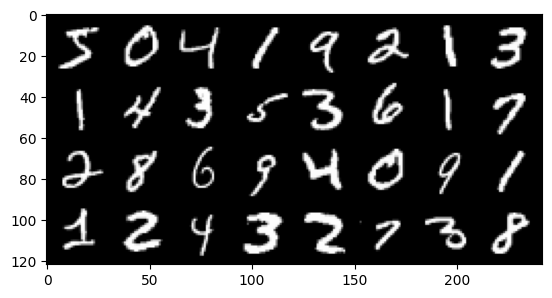

In [11]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

#### Build network

Next, we build a network that will be used to train our model.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        prob = self.linear_relu_stack(x)
        return prob

#### Train Model 

Below we create two functions.  The first called `train_loop` performs an epoch in the training process.  The second function called `main` does everything we need to train a model: download and setup a dataloader, instatiate our model, loss and optizer, and finally run multiple epochs by calling the `train_loop` function.

In [14]:
def train_loop(device, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # transfer data to GPU if available
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def main(device):

    # Setup Dataloader
    train_dataloader=prepare_data(batch_size=4)
    
    # Instantiate Model 
    model = Net().to(device)
    
    # instantiate loss and optimizer 
    loss_fn = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train Model 
    epochs = 3
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(device, train_dataloader, model, loss_fn, optimizer)
        
    print("Done!")
    return model

Finally, let's train our model by calling the `main` function.

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = main(device)

Epoch 1
-------------------------------
loss: 2.332324  [    0/60000]
loss: 0.038365  [ 4000/60000]
loss: 0.003210  [ 8000/60000]
loss: 0.082338  [12000/60000]
loss: 0.496619  [16000/60000]
loss: 0.293197  [20000/60000]
loss: 0.008832  [24000/60000]
loss: 0.001649  [28000/60000]
loss: 0.357726  [32000/60000]
loss: 0.008978  [36000/60000]
loss: 0.009988  [40000/60000]
loss: 0.062887  [44000/60000]
loss: 0.142757  [48000/60000]
loss: 0.000863  [52000/60000]
loss: 0.149190  [56000/60000]
Epoch 2
-------------------------------
loss: 0.061635  [    0/60000]
loss: 0.000433  [ 4000/60000]
loss: 0.003115  [ 8000/60000]
loss: 1.457716  [12000/60000]
loss: 0.005362  [16000/60000]
loss: 0.520599  [20000/60000]
loss: 0.000431  [24000/60000]
loss: 0.000130  [28000/60000]
loss: 0.487031  [32000/60000]
loss: 0.011384  [36000/60000]
loss: 0.000053  [40000/60000]
loss: 0.019879  [44000/60000]
loss: 0.080524  [48000/60000]
loss: 0.000166  [52000/60000]
loss: 0.037261  [56000/60000]
Epoch 3
------------

### Distributed Code for Multiple GPUs on One Node.

Note we will re-use the code from above and modify it to use Pytorch's DDP.  As we mentioned previously there are five main modifications needed to run DDP: 

1. Create a process group
2. Use Pytorch's DistributedSampler to ensure that data passed to each GPU is different
3. Wrap Model with Pytorch's DistributedDataParallel
4. Modify Training Loop to write model from one GPU
5. Close process group

The modifications needed for the five changes highlighted above are visually denoted with two lines of `#`.  Note, we reuse the class for `Net` defined in the serial version above.  Note that in the serial code we use the variable `device` to refer to the gpu or cpu we are using to run the code.  In the distributed implementation we will use the variables `local_rank` and `world_size` where:

- `local_rank`: the device id of a gpu on one node
- `world_size`: the number of gpus on one node.

Note, world size will change when we use multiple nodes later on in this course. 


In [ ]:
#################################################
# 1. Create a process group (function)
def init_distributed(local_rank, world_size):
    '''
    local_rank: identifier for pariticular GPU on one node
    world: total number of process in a the group
    '''
    os.environ['MASTER_ADDR'] = 'localhost'           # IP address of rank 0 process
    os.environ['MASTER_PORT'] = '12355'               # a free port used to communicate amongst processors
    torch.cuda.set_device(local_rank)                       #
    dist.init_process_group("nccl",                   # backend being used; nccl typically used with distributed GPU training
                            rank=local_rank,          # rank of the current process being used
                            world_size=world_size)    # total number of processors being used
#################################################  
    
def prepare_data(local_rank, world_size, batch_size=32):

    trainset = torchvision.datasets.MNIST(
                            root="data",                                        # path to where data is stored
                            train=True,                                         # specifies if data is train or test
                            download=True,                                      # downloads data if not available at root
                            transform=torchvision.transforms.ToTensor()         # trasforms both features and targets accordingly
                            )

    # pass data to the distributed sampler and dataloader
    train_dataloader = DataLoader(trainset,
                                  ################################################
                                  # 2. Setup Dataloader with Distributed Sampler
                                  shuffle=False,
                                  sampler=DistributedSampler(trainset, num_replicas=world_size, rank=local_rank),
                                  ################################################
                                  batch_size=batch_size)

    return train_dataloader

# training loop for one epoch
def train_loop(local_rank, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # transfer data to GPU if available
        X = X.to(local_rank)
        y = y.to(local_rank)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ################################################
        # 4. Only write/print model information on one GPU
        if local_rank == 0:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        ################################################

def main(local_rank, world_size):
    ################################################
    # 1. Set up Process Group
    init_distributed(local_rank, world_size)
    ################################################

    ################################################
    # 2. Setup Dataloader with Distributed Sampler
    train_dataloader = prepare_data(local_rank, world_size)
    ################################################

    ################################################
    # 3. Wrap Model with DDP
    model = DDP(Net().to(local_rank),
        device_ids=[local_rank],                  # list of gpu that model lives on
        output_device=local_rank,                 # where to output model
    )
    ################################################

    # instantiate loss and optimizer
    loss_fn = torch.nn.CrossEntropyLoss() #torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train Model
    epochs = 10
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(local_rank, train_dataloader, model, loss_fn, optimizer)

    #################################################
    # 5. Close Process Group
    dist.destroy_process_group()
    #################################################
    print("Done!")
    return model

To run this code in parallel we will utilize the `torch.multiprocessing` package which is a wrapper around Python's native multiprocessing module. In particular, we will use the `spawn` method.  Spawn creates new processes from the parent process but will only inherit the resources necessary to run the `run()` method. Below we highlight the code used to execute training in a python script called `mnist_parallel.py` that we will run to execute the parallel implemention of this code.

```python
if __name__ == "__main__":
    world_size= torch.cuda.device_count()
    print('world_size = {}'.format(world_size))
    mp.spawn(main, args=(world_size,) , nprocs=world_size)
```

Finally we can run train the MNIST classifier using DDP. 

In [5]:
!python mnist_parallel.py

world_size = 4
Epoch 1
-------------------------------
loss: 2.323778  [    0/60000]
loss: 0.162850  [ 3200/60000]
loss: 0.152105  [ 6400/60000]
loss: 0.080957  [ 9600/60000]
loss: 0.087677  [12800/60000]
Epoch 2
-------------------------------
loss: 0.218993  [    0/60000]
loss: 0.186821  [ 3200/60000]
loss: 0.220338  [ 6400/60000]
loss: 0.053301  [ 9600/60000]
loss: 0.039036  [12800/60000]
Epoch 3
-------------------------------
loss: 0.187737  [    0/60000]
loss: 0.123499  [ 3200/60000]
loss: 0.098414  [ 6400/60000]
loss: 0.022703  [ 9600/60000]
loss: 0.036694  [12800/60000]
Epoch 4
-------------------------------
loss: 0.176670  [    0/60000]
loss: 0.126830  [ 3200/60000]
loss: 0.194266  [ 6400/60000]
loss: 0.023831  [ 9600/60000]
loss: 0.026895  [12800/60000]
Epoch 5
-------------------------------
loss: 0.063774  [    0/60000]
loss: 0.073143  [ 3200/60000]
loss: 0.105964  [ 6400/60000]
loss: 0.045004  [ 9600/60000]
loss: 0.015466  [12800/60000]
Epoch 6
---------------------------

## References 

1. https://www.nature.com/articles/s41598-021-82543-3
2. https://arxiv.org/abs/2006.15704
3. https://pytorch.org/tutorials/beginner/ddp_series_theory.html